<a href="https://colab.research.google.com/github/Lisker2/CS309_Project/blob/main/Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
from proteinbert import load_pretrained_model
pretrained_model_generator, input_encoder = load_pretrained_model("")

In [ ]:
# read the orginal data
non_cv = pd.read_csv('bert-enhancer/data/non.cv.txt')[::2]
non_cv.columns = ['seq']

label_1 = [0 for i in range(len(non_cv))]
non_cv['label'] = label_1

enhancer_cv = pd.read_csv('bert-enhancer/data/enhancer.cv.txt')[::2]
enhancer_cv.columns = ['seq']

label_1 = [1 for i in range(len(enhancer_cv))]
enhancer_cv['label'] = label_1

non_ind = pd.read_csv('bert-enhancer/data/non.ind.txt')[::2]
non_ind.columns = ['seq']

label_1 = [0 for i in range(len(non_ind))]
non_ind['label'] = label_1

enhancer_ind = pd.read_csv('bert-enhancer/data/enhancer.ind.txt')[::2]
enhancer_ind.columns = ['seq']

label_1 = [1 for i in range(len(enhancer_ind))]
enhancer_ind['label'] = label_1

# concat data with label 1 and 0 seperately -- shuffled
enhancer_total = pd.concat([enhancer_cv, enhancer_ind],axis=0).sample(frac=1.0).reset_index(drop=True)
non_total = pd.concat([non_cv, non_ind ],axis=0).sample(frac=1.0).reset_index(drop=True)

# 1684 in total train = 1384 valid = 150 test = 150
train = pd.concat([enhancer_total[:1384], non_total[:1384]],axis=0).sample(frac=1.0).reset_index(drop=True)
valid = pd.concat([enhancer_total[1384:1534], non_total[1384:1534]],axis=0).sample(frac=1.0).reset_index(drop=True)
test = pd.concat([enhancer_total[1534:], non_total[1534:]],axis=0).sample(frac=1.0).reset_index(drop=True)

# max len
enhancer_sequence_length = train['seq'].map(lambda x: len(x)).max() + 2
print('sequence_length', enhancer_sequence_length)


sequence_length 202


In [ ]:
OUTPUT_TYPE = OutputType(False, 'binary')
UNIQUE_LABELS = [0, 1]
OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)

model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)
training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]
finetune(model_generator, input_encoder, OUTPUT_SPEC, train['seq'], train['label'], valid['seq'], valid['label'], 
        seq_len = enhancer_sequence_length, batch_size = 32, 
         max_epochs_per_stage = 40, lr = 1e-04, begin_with_frozen_pretrained_layers = True, 
        lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, 
         final_lr = 1e-05, callbacks = training_callbacks)

[2023_05_04-19:20:22] Training set: Filtered out 0 of 2768 (0.0%) records of lengths exceeding 200.
[2023_05_04-19:20:22] Validation set: Filtered out 0 of 300 (0.0%) records of lengths exceeding 200.
[2023_05_04-19:20:22] Training with frozen pretrained layers...
Epoch 1/40
87/87 [==============================] - 35s 314ms/step - loss: 0.6589 - val_loss: 0.6968
Epoch 2/40
87/87 [==============================] - 40s 464ms/step - loss: 0.6265 - val_loss: 0.5454
Epoch 3/40
87/87 [==============================] - 44s 502ms/step - loss: 0.6161 - val_loss: 0.6110

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 4/40
87/87 [==============================] - 41s 469ms/step - loss: 0.5729 - val_loss: 0.5764

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
[2023_05_04-19:23:04] Training the entire fine-tuned model...
[2023_05_04-19:23:15] Incompatible number of optimizer weights - will not initialize them.
Epoch 1/40
87/87

In [ ]:
results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test['seq'], test['label'],
        start_seq_len = enhancer_sequence_length, start_batch_size = 32)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

Test-set performance:


,# records,AUC
Model seq len,,
202,300,0.836533
All,300,0.836533


Confusion matrix:


,0,1
0,112,38
1,29,121


In [ ]:
results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, train['seq'], train['label'],
        start_seq_len = enhancer_sequence_length, start_batch_size = 32)

print('Train-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

Train-set performance:


,# records,AUC
Model seq len,,
202,2768,0.849304
All,2768,0.849304


Confusion matrix:


,0,1
0,921,463
1,229,1155


CCCACTCCTGCCCGCCAGAGAACAAACCCCCTTTGACTGTAATTTTCCTTTACCTACCCAAATCCTATAAAATGGCCCCACCGTTATCTCCCTTTGCTGACTCTCTTTTCGGACTCAGCCCACCTGCACCCAGGTGAAATAAACAGCCATGTTGCTCACACAAAGCCTGTTTGGTGGTCTCTTCACACGGACGCGCATGA 1


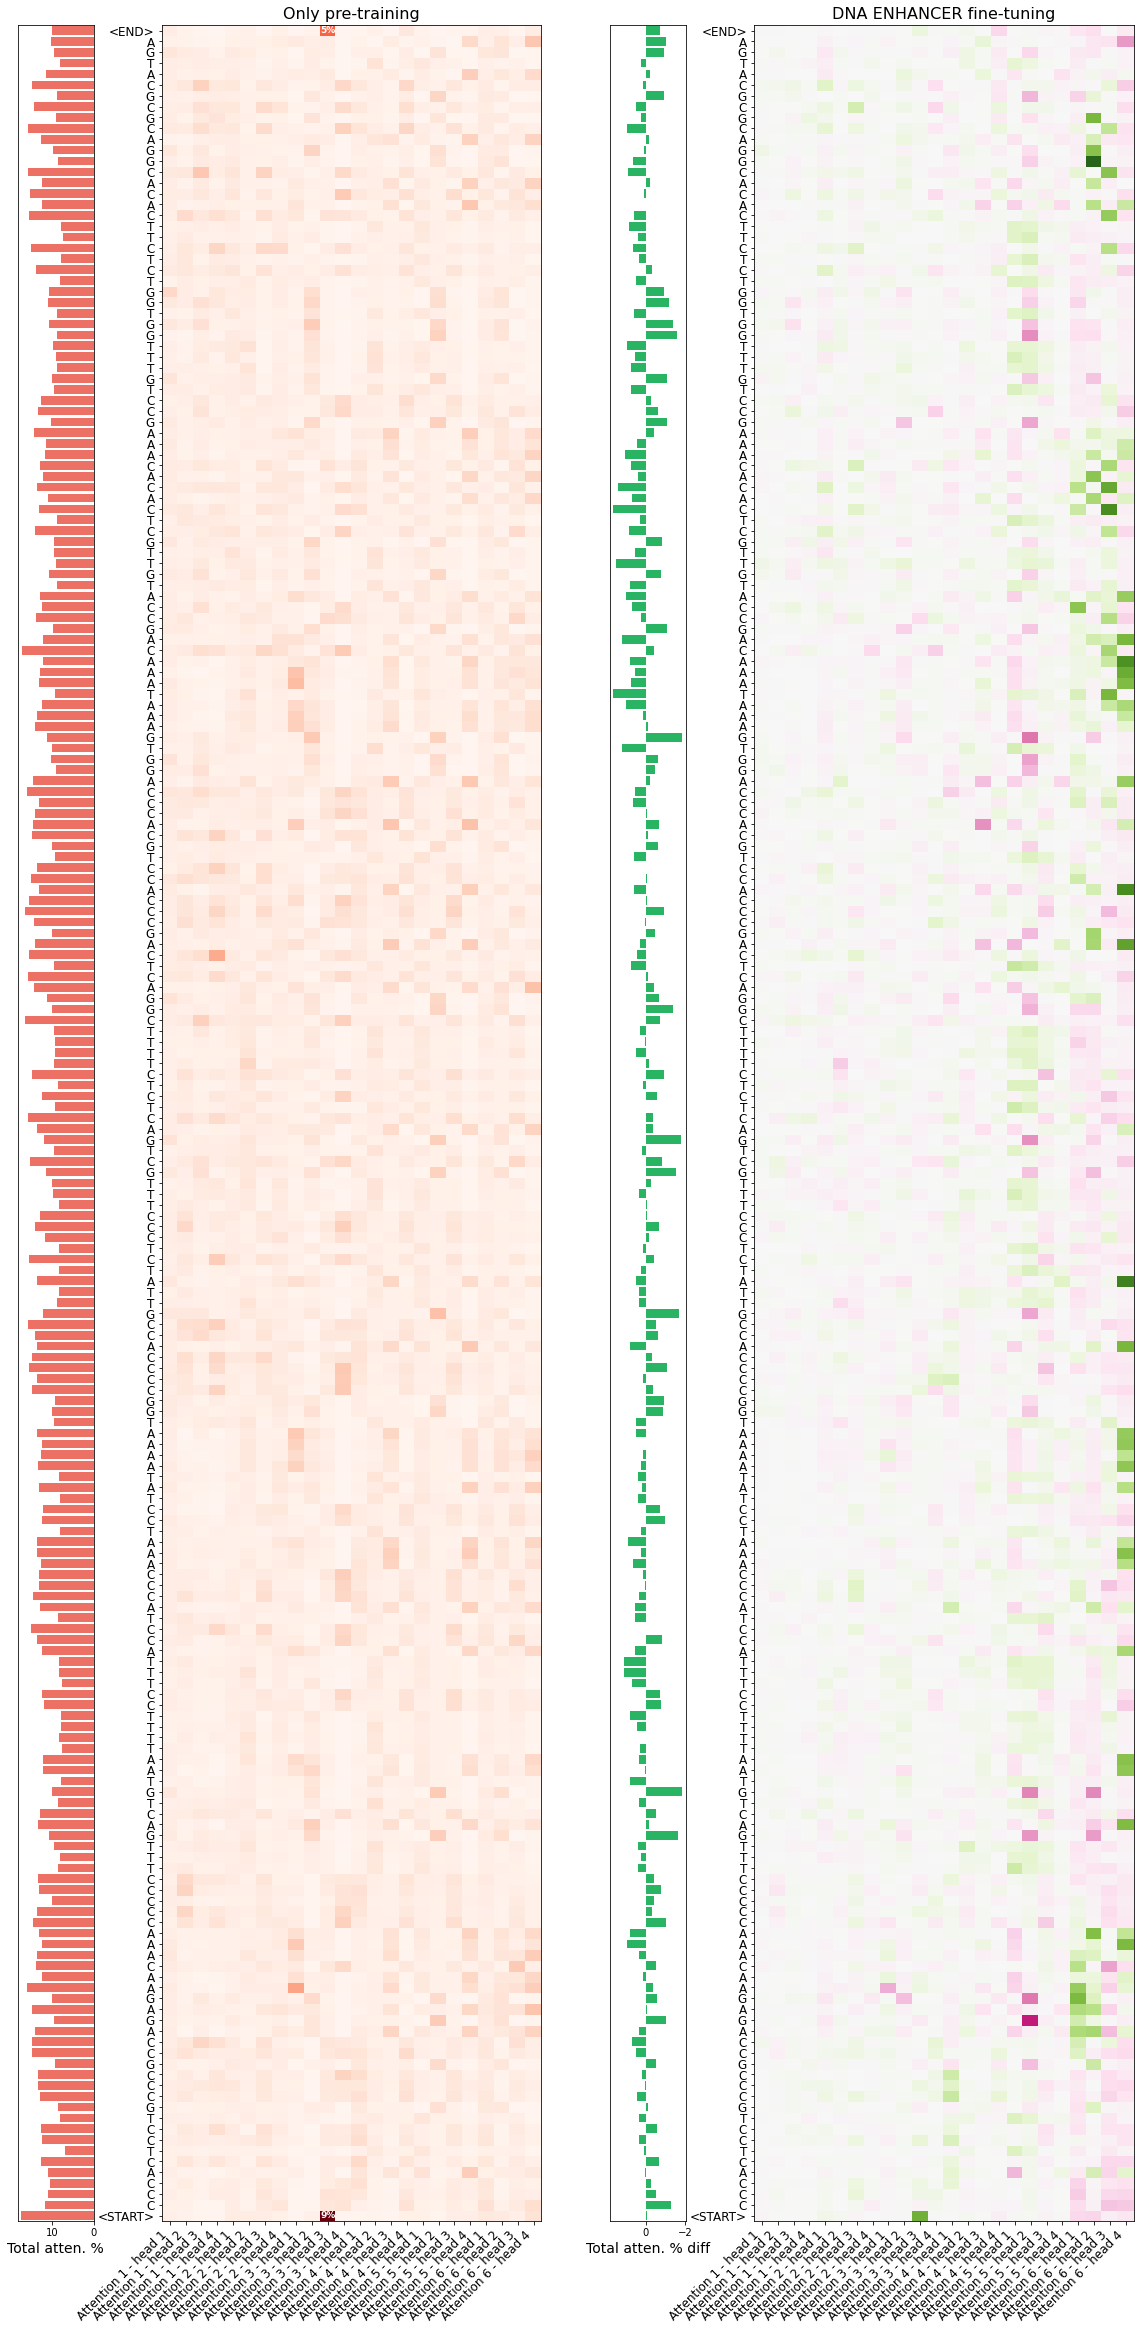

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def calculate_attentions(model, input_encoder, seq, seq_len = None):
    
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    
    if seq_len is None:
        seq_len = len(seq) + 2
    
    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    model_inputs = [layer.input for layer in model.layers if 'InputLayer' in str(type(layer))][::-1]
    model_attentions = [layer.calculate_attention(layer.input) for layer in model.layers if 'GlobalAttention' in str(type(layer))]
    invoke_model_attentions = K.function(model_inputs, model_attentions)
    attention_values = invoke_model_attentions(X)
    
    attention_labels = []
    merged_attention_values = []

    for attention_layer_index, attention_layer_values in enumerate(attention_values):
        for head_index, head_values in enumerate(attention_layer_values):
            attention_labels.append('Attention %d - head %d' % (attention_layer_index + 1, head_index + 1))
            merged_attention_values.append(head_values)

    attention_values = np.array(merged_attention_values)
    
    return attention_values, seq_tokens, attention_labels

def plot_attention(attention_values, seq_tokens, attention_labels, ax, cmap = 'Reds', vmin = 0, vmax = None, text_value_threshold = 0.1):

    heatmap = ax.pcolor(attention_values.transpose(), cmap = cmap, vmin = vmin, vmax = vmax)

    ax.set_xticks(np.arange(len(attention_labels)) + 0.5)
    ax.set_xticklabels(attention_labels, rotation = 45, ha = 'right', fontsize = 12)
    ax.set_yticks(np.arange(len(seq_tokens)) + 0.5)
    ax.set_yticklabels(seq_tokens, fontsize = 12)

    for i, row in enumerate(attention_values):
        for j, value in enumerate(row):
            if abs(value) >= text_value_threshold:
                add_plus_sign = attention_values.min() < 0 and value > 0
                plus_sign = '+' if add_plus_sign else ''
                ax.text(i + 0.5, j + 0.5, plus_sign + '%d%%' % (100 * value), color = 'white', ha = 'center', va = 'center', \
                        fontsize = 9, fontweight = 'bold', fontstretch = 'condensed')
                
chosen_index = ((test['seq'].str.len()).abs()).sort_values().index[0]
seq = test.loc[chosen_index, 'seq']
label = test.loc[chosen_index, 'label']
                
seq_len = enhancer_sequence_length 

model = pretrained_model_generator.create_model(seq_len)
pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)

model = model_generator.create_model(seq_len)
finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)
assert finetuned_seq_tokens == pretrained_seq_tokens
assert finetuned_attention_labels == pretrained_attention_labels[:len(finetuned_attention_labels)]

fig, axes = plt.subplots(ncols = 4, figsize = (20, 0.2 * seq_len), gridspec_kw = dict(width_ratios = [1, 5, 1, 5]))
fig.subplots_adjust(wspace = 0.3)

axes[0].barh(np.arange(seq_len), 100 * pretrained_attention_values.sum(axis = 0), color = '#EC7063')
axes[0].set_ylim((-0.5, seq_len - 0.5))
axes[0].set_yticks([])
axes[0].invert_xaxis()
axes[0].set_xlabel('Total atten. %', fontsize = 14)

vmax = pretrained_attention_values.max()
plot_attention(pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels, axes[1], cmap = 'Reds', vmax = vmax, \
        text_value_threshold = 0.05)
axes[1].set_title('Only pre-training', fontsize = 16)

axes[2].barh(np.arange(seq_len), 100 * (finetuned_attention_values - pretrained_attention_values).sum(axis = 0), color = '#28B463')
axes[2].set_ylim((-0.5, seq_len - 0.5))
axes[2].set_yticks([])
axes[2].invert_xaxis()
axes[2].set_xlabel('Total atten. % diff', fontsize = 14)

attention_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]
vmax = np.abs(attention_diff).max()
plot_attention(attention_diff, finetuned_seq_tokens, finetuned_attention_labels, axes[3], cmap = 'PiYG', vmin = -vmax, vmax = vmax, \
        text_value_threshold = 0.03)
axes[3].set_title('%s fine-tuning' % "DNA ENHANCER", fontsize = 16)

print(seq, label)